In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from lattice_utils import (
    Corr2PtDataset,
    xy_hamiltonian,
    corr_2d,
    helicity_modulus,
    mean_squared_mag,
    load_temp_range,
    bin_bootstrap,
    reweight,
)
from models import Corr2PtUNet, Corr2PtConv1Layer 
from engines import train

In [2]:
import re, os
print("Torch:", torch.__version__)
print("HIP arch list:", re.findall(r'gfx\\d+', torch.version.hip))
print("Override:", os.getenv("HSA_OVERRIDE_GFX_VERSION"))

Torch: 2.6.0+rocm6.4.1.git1ded221d
HIP arch list: []
Override: 11.0.0


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.6.0+rocm6.4.1.git1ded221d
True
AMD Radeon™ RX 7700S


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Loading in the data for a range of temperatures**

In [8]:
temp_range = np.linspace(0.6, 1.1, 21)
# lats, temps = load_temp_range(temp_range, 64, dir='train_configs')
# torch.save((lats, temps), 'torch_data/L_64_temps_0.40-1.00_31-train.pt')

In [6]:
lats, temps = torch.load("torch_data/L_64_temps_0.60-1.10_21-train.pt")

**Susceptibility and helicity modulus plots**

In [9]:
stiffness = [helicity_modulus(lats[i], temp_range[i]) for i in range(temp_range.size)]
mag_squared = [mean_squared_mag(lats[i]) for i in range(temp_range.size)]

In [10]:
stiff_mean = np.zeros(temp_range.size)
stiff_lower = np.zeros(temp_range.size)
stiff_upper = np.zeros(temp_range.size)

mag_sq_mean = np.zeros(temp_range.size)
mag_sq_lower = np.zeros(temp_range.size)
mag_sq_upper = np.zeros(temp_range.size)

for i in range(temp_range.size):
    stiff_mean[i], stiff_lower[i], stiff_upper[i] = bin_bootstrap(
        stiffness[i], np.mean, 1000, 99
    )
    mag_sq_mean[i], mag_sq_lower[i], mag_sq_upper[i] = bin_bootstrap(
        mag_squared[i], np.mean, 1000, 99
    )

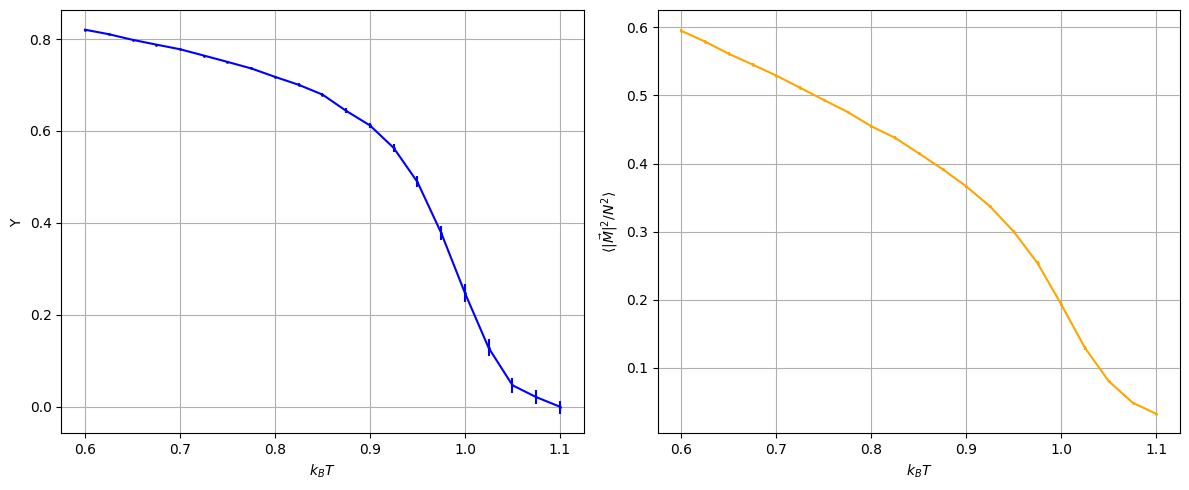

In [11]:
# Create two subplots side by side (no shared y-axis)
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))  # sharey removed

# Plot on the first axis
axes[0].errorbar(
    temp_range,
    stiff_mean,
    yerr=(stiff_mean - stiff_lower, stiff_upper - stiff_mean),
    color="blue",
    ls="-",
    marker="o",
    ms=1,
)
# axes[0].set_title('Dataset 1')
axes[0].set_xlabel("$k_B T$")
axes[0].set_ylabel("$\\Upsilon$")
axes[0].grid(True)

# Plot on the second axis
axes[1].errorbar(
    temp_range,
    mag_sq_mean,
    yerr=(mag_sq_mean - mag_sq_lower, mag_sq_upper - mag_sq_mean),
    color="orange",
    ls="-",
    marker="o",
    ms=1,
)
# axes[1].set_title('Dataset 2')
axes[1].set_xlabel("$k_B T$")
axes[1].set_ylabel(
    "$\\langle |\\vec{M}|^2/N^2 \\rangle$"
)  # Optional: include if you want separate y labels
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Using the single layer convolutional network for fixed temperature and variable separation**

Separation is limited to at least the kernel size

In [26]:
conv1layer = Corr2PtConv1Layer(lat_size=64, hamiltonian=xy_hamiltonian, kernel_size=17)
conv1layer.to(device)

Corr2PtConv1Layer(
  (conv): Conv2d(1, 1, kernel_size=(17, 17), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)

In [27]:
temp = 1.0
temp_idx = np.where(temp_range == temp)[0][0]
temp_idx

np.int64(16)

In [28]:
n = lats[temp_idx].size(0)
x, y = torch.randint(17, 47, (n,)), torch.randint(17, 47, (n,))

dataset = Corr2PtDataset(lats[temp_idx], temps[temp_idx], x, y)

sampler = torch.utils.data.WeightedRandomSampler(
    reweight(dataset.temps.numpy()), dataset.temps.size(0)
)

loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=sampler)

optim = torch.optim.Adam(conv1layer.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 40, 1e-5)

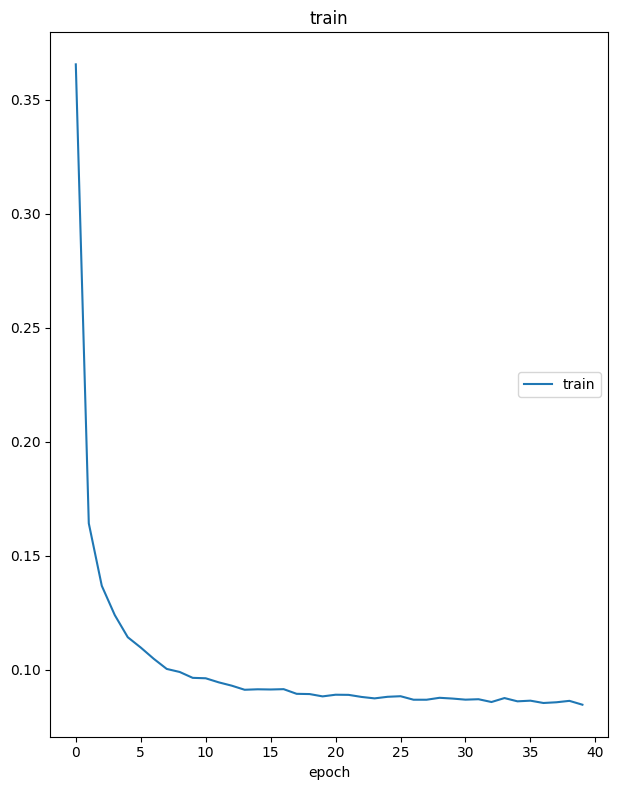

train
	train            	 (min:    0.085, max:    0.366, cur:    0.085)


In [29]:
train(conv1layer, device, loader, optim, epochs=40, scheduler=scheduler)

In [30]:
conv1layer.to("cpu")

x, y = torch.ones(n) * 27, torch.ones(n) * 34

init = corr_2d(dataset.lats, x, y).detach().numpy()
xi, yi = init.real, init.imag

final = conv1layer(dataset.lats, dataset.temps, x, y).detach().numpy()
xf, yf = final.real, final.imag

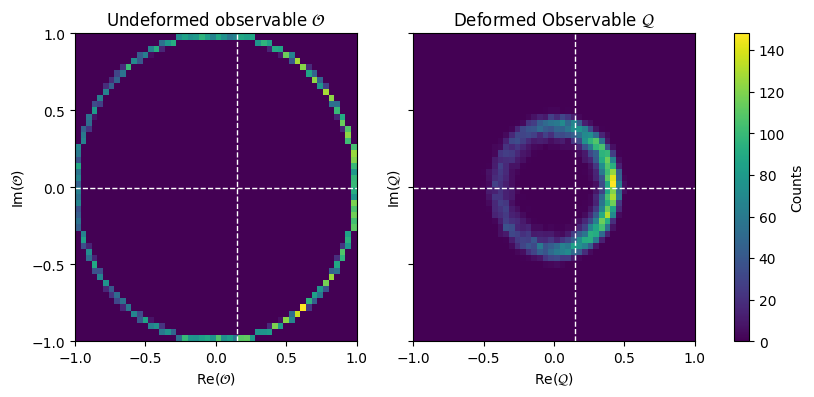

In [31]:
x_means = (xi.mean(), xf.mean())
y_means = (yi.mean(), yf.mean())

xlim = (-1, 1)
ylim = (-1, 1)
# --- Create Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot histograms and store images
h1 = axes[0].hist2d(xi, yi, bins=50, range=[xlim, ylim])
h2 = axes[1].hist2d(xf, yf, bins=50, range=[xlim, ylim])

# Titles and labels
axes[0].set_title("Undeformed observable $\\mathcal{O}$")
axes[1].set_title("Deformed Observable $\\mathcal{Q}$")

axes[0].set_xlabel("$\\mathrm{Re}(\\mathcal{O})$")
axes[0].set_ylabel("$\\mathrm{Im}(\\mathcal{O})$")

axes[1].set_xlabel("$\\mathrm{Re}(\\mathcal{Q})$")
axes[1].set_ylabel("$\\mathrm{Im}(\\mathcal{Q})$")

for i in range(len(axes)):
    axes[i].set_xticks(np.linspace(-1, 1, 5))
    axes[i].set_yticks(np.linspace(-1, 1, 5))
    axes[i].vlines(x_means[i], ymin=-1, ymax=1, color="white", ls="--", lw=1)
    axes[i].hlines(y_means[i], xmin=-1, xmax=1, color="white", ls="--", lw=1)


# --- Shared Colorbar ---
# Use the mappable from one of the histograms (e.g. h1[3])
cbar = fig.colorbar(h1[3], ax=axes.ravel().tolist(), orientation="vertical")
cbar.set_label("Counts")

plt.show()

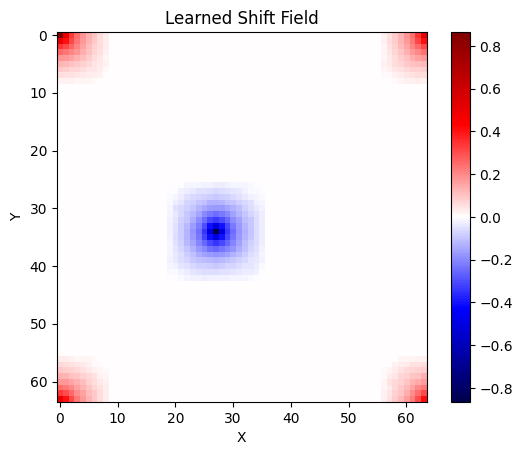

In [32]:
plt.imshow(conv1layer.shifts.detach().numpy()[0], cmap="seismic")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Learned Shift Field")
plt.colorbar()

**U-Net architecture for temperation and separation generalization**

Separation allowed to vary over the full lattice, and a set temperatures is used for training

Consider boltzmann reweighting to interpolate between temperatures?

Loss function:
$$\frac{1}{L^2}\sum_{x,y}\int_{T_0}^{T_1}dT\,\rho(T)\cdot\mathrm{Re}\left(\left\langle \mathcal{Q}(T,x,y)^2 \right\rangle\right)$$

With $\rho(T)$ some probability density that has support over $[T_0,T_1]$. Currently using a uniform distribtion, but could try reweighting to uniform sampling in $\beta$ rather than $T$, which amounts to the change of variables $d\beta=-dT/T^2$

In [37]:
unet = Corr2PtUNet(64, xy_hamiltonian, min_size=4)
unet.to(device)

Corr2PtUNet(
  (encoder_expand_convs): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  )
  (encoder_refine_convs): ModuleList(
    (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1

In [38]:
lats_full = torch.cat(lats)
temps_full = torch.cat(temps)
x, y = torch.randint(1, 63, temps_full.size()), torch.randint(1, 63, temps_full.size())

unet_train = Corr2PtDataset(lats_full, temps_full, x, y)

train_temps = unet_train.temps.numpy()
unet_sampler = torch.utils.data.WeightedRandomSampler(
    reweight(train_temps), train_temps.size
)

In [39]:
unet_loader = torch.utils.data.DataLoader(
    dataset=unet_train, batch_size=64, sampler=unet_sampler
)

unet_optim = torch.optim.Adam(unet.parameters(), lr=1e-3)
unet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(unet_optim, 250, 1e-5)

In [ ]:
train(unet, device, unet_loader, unet_optim, epochs=250, scheduler=unet_scheduler)

In [ ]:
test_data = (
    np.zeros(temp_range.size, 64, 64),
    torch.from_numpy(temp_range),
    33 * torch.ones(temp_range.size),
    33 * torch.ones(temp_range.size),
)

In [39]:
# Save model and optimizer state
torch.save(
    {
        "model_state_dict": unet.state_dict(),
        "optimizer_state_dict": unet_optim.state_dict(),
    },
    "torch_data/unet_64_ADAM_ConsineAnnealingLR_checkpoint.pt",
)